In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import time as time
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, make_scorer
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from xgboost import XGBClassifier


# from make_model import make_model
import sys
path = os.getcwd()
sys.path.append(path+'/scripts')
import param_grids
from make_model_3 import make_model_l, make_model_nl

In [2]:
data = path + '/dataset/bank/bank-additional/bank-additional-full.csv'
df_orig = pd.read_csv(data, sep=';')
print(f'size of the data --> {df_orig.shape}')
df_orig.head()

size of the data --> (41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
# create table listing column types etc
df = df_orig.copy()        # make a copy of the data before any transformations

df_info = pd.DataFrame([df.columns,df.dtypes, df.isna().sum(), df.nunique()])
df_info = df_info.T
df_info.columns = ['column','dtype','NA_count', 'unique_count']
print(f'Duplicates dropped --> {df.duplicated().sum()}')
# drop duplicates, 12 rows
df = df.drop_duplicates()
df_info

Duplicates dropped --> 12


,column,dtype,NA_count,unique_count
0,age,int64,0,78
1,job,object,0,12
2,marital,object,0,4
3,education,object,0,8
4,default,object,0,3
5,housing,object,0,3
6,loan,object,0,3
7,contact,object,0,2
8,month,object,0,10
9,day_of_week,object,0,5


### Decision Trees

- Tuned hyperparameters have been found in feature_selection.ipynb
- Update hyperparameters in param_grids.py or manually in this notebook
- Compare Decision Tree model with ensemble models using DecisionTreeClassifier

Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 100}
Accuracy : 0.9355939363776962
Training Time : 4 minutes
Test Score : 0.9369769657330773


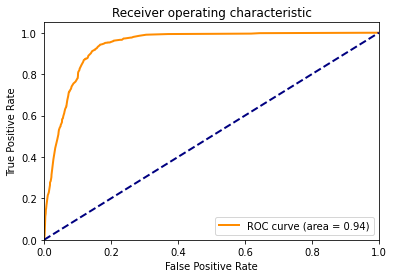

In [11]:
random_state = 42
folds = 5
model_name = f'new_dt_{folds}'
model = DecisionTreeClassifier(random_state=random_state)
parameters = param_grids.param_dt

df = df_orig.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

In [ ]:
from sklearn.tree import plot_tree

# Load the trained model from disk
model_name = f'new_dt_{folds}'
loaded_model = pickle.load(open(f'trained_models/{model_name}.pkl', 'rb'))

# Get the best estimator (trained decision tree) from the GridSearchCV object
best_tree = loaded_model.best_estimator_.named_steps['classifier']

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(best_tree, feature_names=df.drop('y', axis=1).columns, class_names=['no', 'yes'], filled=True, rounded=True)
plt.show()


### Random Forest

Tuned Hyperparameters : {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5}
Accuracy : 0.9438728006148438
Training Time : 1 minutes
Test Score : 0.9424278792467531


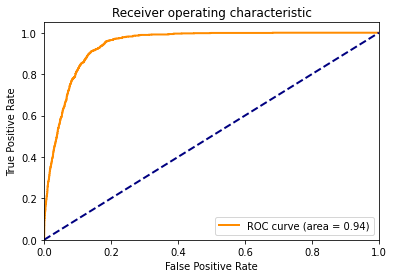

In [12]:
random_state = 42
folds = 5
model_name = f'new_rf_{folds}'
model = RandomForestClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_rf

df = df_orig.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### AdaBoost

Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=1), 'classifier__n_estimators': 300}
Accuracy : 0.9396568245053366
Training Time : 3 minutes
Test Score : 0.9402804942075668


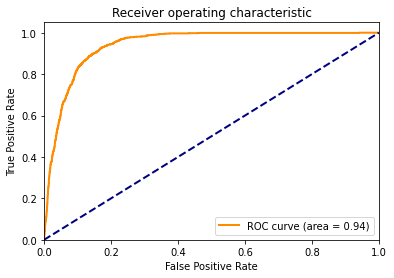

In [13]:
random_state = 42
folds = 5
model_name = f'new_ada_{folds}'
model = AdaBoostClassifier(random_state=random_state)
parameters = param_grids.param_ada

df = df_orig.copy()

clf_grid, time, test_score = make_model_nl(df, model, parameters,test_size = 0.2, folds=folds)

# save the model to disk
pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
        # Write the tuned hyperparameters and accuracy to file
        f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
        f.write(f"Accuracy: {clf_grid.best_score_}\n")
        # Write training time in minutes to file
        f.write(f"Training Time: {time} minutes\n")
        f.write(f"Test Score: {test_score}\n")

### XGBoost

In [14]:
random_state = 42
folds = 5

model_name = f'new_xgb_{folds}'
model = XGBClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_xgb  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_orig.copy()

# Replace 'no' and 'yes' with 0 and 1, respectively
df['y'] = df['y'].map({'no': 0, 'yes': 1})

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


KeyboardInterrupt: 

### Bagging

Tuned Hyperparameters : {'classifier__base_estimator': LogisticRegression(C=1, solver='liblinear'), 'classifier__n_estimators': 300}
Accuracy : 0.936256610066798
Training Time : 1 minutes
Test Score : 0.9370338612583944


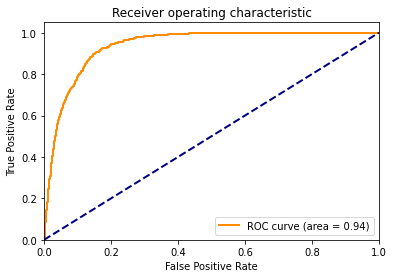

In [15]:
random_state = 42
folds = 5

model_name = f'new_bag_{folds}'
model = BaggingClassifier(random_state=random_state, n_jobs=-1)
parameters = param_grids.param_bag  # Check in param_grids.py for the parameters, uncomment if you want to test different boosters like linear or dart

df = df_orig.copy()

# Replace 'no' and 'yes' with 0 and 1, respectively
df['y'] = df['y'].map({'no': 0, 'yes': 1})

clf_grid, time, test_score = make_model_nl(df, model, parameters, test_size=0.2, folds=folds)

pickle.dump(clf_grid, open(f'trained_models/{model_name}.pkl', 'wb'))

output_file = f'trained_models/{model_name}.txt'

with open(output_file, 'w') as f:
    # Write the tuned hyperparameters and accuracy to file
    f.write(f"Tuned Hyperparameters: {clf_grid.best_params_}\n")
    f.write(f"Accuracy: {clf_grid.best_score_}\n")
    # Write training time in minutes to file
    f.write(f"Training Time: {time} minutes\n")
    f.write(f"Test Score: {test_score}\n")


- BaggingClassifier gives better estimates when using LogisticRegression as base estimator.

# Compare models 

### Define tuned hyperparameters

In [ ]:
param_dt = {
    'classifier__max_depth' : [10],
    'classifier__min_samples_split' : [100],
    'classifier__min_samples_leaf'  : [15],
}
param_rf = {
    'classifier__max_depth'    : [10],
    'classifier__min_samples_split' : [5],
    'classifier__min_samples_leaf'  : [1],
}
param_ada = {
    'classifier__n_estimators' : [300],
    'classifier__base_estimator' : [DecisionTreeClassifier(max_depth=2)],
}   
param_xgb = {
    'classifier__max_depth' : [6],
     'classifier__gamma' : [0.2],
    'classifier__eval_metric' : ['auc'],
    'classifier__booster' : ['gbtree'],
}
param_bag = {
    'classifier__n_estimators' : [300],
    'classifier__base_estimator' : [DecisionTreeClassifier(max_depth=2)],
}

Training DecisionTree...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 15, 'classifier__min_samples_split': 100}
Accuracy : 0.9359201625985871
Training Time : 0 minutes
Test Score : 0.9342732200743816


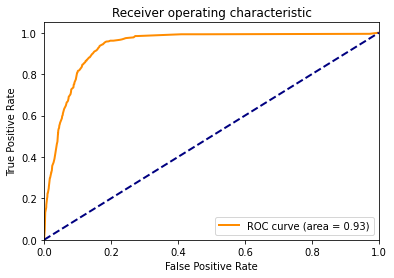

Confusion Matrix:
[[6548  755]
 [ 171  764]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7303
           1       0.50      0.82      0.62       935

    accuracy                           0.89      8238
   macro avg       0.74      0.86      0.78      8238
weighted avg       0.92      0.89      0.90      8238

Training RandomForest...
Tuned Hyperparameters : {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5}
Accuracy : 0.9397205054141462
Training Time : 0 minutes
Test Score : 0.9389453165902812


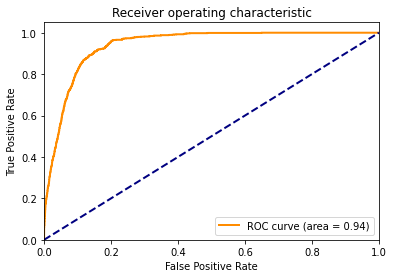

Confusion Matrix:
[[6617  686]
 [ 187  748]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.52      0.80      0.63       935

    accuracy                           0.89      8238
   macro avg       0.75      0.85      0.78      8238
weighted avg       0.92      0.89      0.90      8238

Training AdaBoost...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.93063367811008
Training Time : 1 minutes
Test Score : 0.9314386220299181


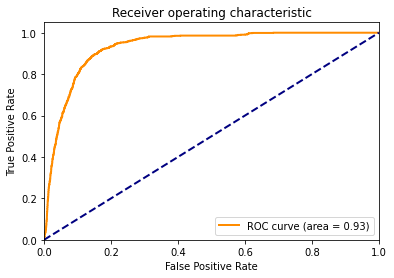

Confusion Matrix:
[[6676  627]
 [ 241  694]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.53      0.74      0.62       935

    accuracy                           0.89      8238
   macro avg       0.75      0.83      0.78      8238
weighted avg       0.92      0.89      0.90      8238

Training XGBoost...
Tuned Hyperparameters : {'classifier__booster': 'gbtree', 'classifier__eval_metric': 'auc', 'classifier__gamma': 0.2, 'classifier__max_depth': 6}
Accuracy : 0.9451143937542872
Training Time : 0 minutes
Test Score : 0.9444888592410563


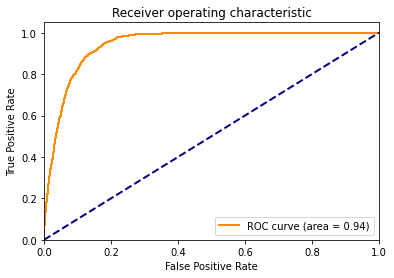

Confusion Matrix:
[[6669  634]
 [ 197  738]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7303
           1       0.54      0.79      0.64       935

    accuracy                           0.90      8238
   macro avg       0.75      0.85      0.79      8238
weighted avg       0.92      0.90      0.91      8238

Training BaggingClassifier...
Tuned Hyperparameters : {'classifier__base_estimator': DecisionTreeClassifier(max_depth=2), 'classifier__n_estimators': 300}
Accuracy : 0.897798232577907
Training Time : 0 minutes
Test Score : 0.903273579607238


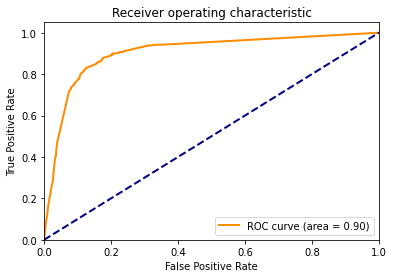

Confusion Matrix:
[[6444  859]
 [ 174  761]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.93      7303
           1       0.47      0.81      0.60       935

    accuracy                           0.87      8238
   macro avg       0.72      0.85      0.76      8238
weighted avg       0.92      0.87      0.89      8238



,Model,Training Time (min),Test Score,Best Hyperparameters
0,DecisionTree,0.030,0.934273,"{'classifier__max_depth': 10, 'classifier__min..."
1,RandomForest,0.092,0.938945,"{'classifier__max_depth': 10, 'classifier__min..."
2,AdaBoost,0.579,0.931439,{'classifier__base_estimator': DecisionTreeCla...
3,XGBoost,0.153,0.944489,"{'classifier__booster': 'gbtree', 'classifier_..."
4,BaggingClassifier,0.160,0.903274,{'classifier__base_estimator': DecisionTreeCla...


,Model,Accuracy,Precision,Recall,F1-score,AUC-ROC,MCC,Log-Loss
0,DecisionTree,0.887594,0.502962,0.817112,0.622657,0.934273,0.583794,3.882436
1,RandomForest,0.894028,0.521618,0.800000,0.631490,0.938945,0.590670,3.660221
2,AdaBoost,0.894635,0.525360,0.742246,0.615248,0.931439,0.567425,3.639252
3,XGBoost,0.899126,0.537901,0.789305,0.639792,0.944489,0.598093,3.484126
4,BaggingClassifier,0.874605,0.469753,0.813904,0.595695,0.903274,0.555674,4.331056


In [36]:
from make_model_5 import make_model

random_state = 42
folds = 5

models = {
    'DecisionTree': DecisionTreeClassifier(random_state=random_state),
    'RandomForest': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'AdaBoost': AdaBoostClassifier(random_state=random_state),
    'XGBoost': XGBClassifier(random_state=random_state, n_jobs=-1),
    'BaggingClassifier': BaggingClassifier(random_state=random_state, n_jobs=-1)
}

parameters = {
    'DecisionTree': param_dt,
    'RandomForest': param_rf,
    'AdaBoost': param_ada,
    'XGBoost': param_xgb,
    'BaggingClassifier': param_bag
}

results = []
metrics_list = []
df = df_orig.copy()
for model_name, model in models.items():
    print(f"Training {model_name}...")
    clf_grid, time, test_score, metrics_df = make_model(df, model, parameters[model_name], test_size=0.2, folds=folds)
    
    # Save the model to disk
    pickle.dump(clf_grid, open(f'trained_models/tuned_{model_name}.pkl', 'wb'))

    results.append({
        'Model': model_name,
        'Training Time (min)': time,
        'Test Score': test_score,
        'Best Hyperparameters': clf_grid.best_params_
    })

    metrics_df['Model'] = model_name
    metrics_list.append(metrics_df)

# Convert results to a pandas DataFrame and display the table
results_df = pd.DataFrame(results)
display(results_df)

# Concatenate metrics DataFrames and display the table
all_metrics_df = pd.concat(metrics_list, ignore_index=True)
all_metrics_df.insert(0, 'Model', all_metrics_df.pop('Model'))
display(all_metrics_df)

In [5]:
from lazypredict.Supervised import LazyClassifier

df = df_orig.copy()
X = df.drop('y', axis=1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

print(models)


 41%|████▏     | 12/29 [06:38<31:59, 112.91s/it]